In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [ ]:
import torch as torch
import torch.nn as nn
device = torch.device("cuda:0")

In [119]:
m = nn.Conv1d(16, 8, 3, stride=2)
inp = torch.randn(100, 16, 60)
out = m(inp)
print(out.shape)
n = nn.Linear(29,29)
n(out).shape

torch.Size([100, 8, 29])


torch.Size([100, 8, 29])

In [7]:
ctl = pd.read_csv('Data/smad_timecourse_singlecells_ctl.csv')
times = ctl['time']
ctl = ctl.drop(columns='time')

In [9]:
tgfb_low = pd.read_csv('Data/smad_timecourse_singlecells_tgfb_low.csv').drop(columns='time')
print(f"tgfb size: {tgfb_low.values.T.shape}")
gdf11_high = pd.read_csv('Data/smad_timecourse_singlecells_gdf11_high.csv').drop(columns='time')
print(f"gdf11 size: {gdf11_high.values.T.shape}")

tgfb size: (1230, 288)
gdf11 size: (2692, 288)


In [79]:
x_total = np.concatenate([ctl.values.T,tgfb_low.values.T,gdf11_high.values.T],axis=0).reshape([-1,1,ctl.shape[0]])
y_total = np.concatenate([np.ones(ctl.shape[1]),2*np.ones(tgfb_low.shape[1]),3*np.ones(gdf11_high.shape[1])])

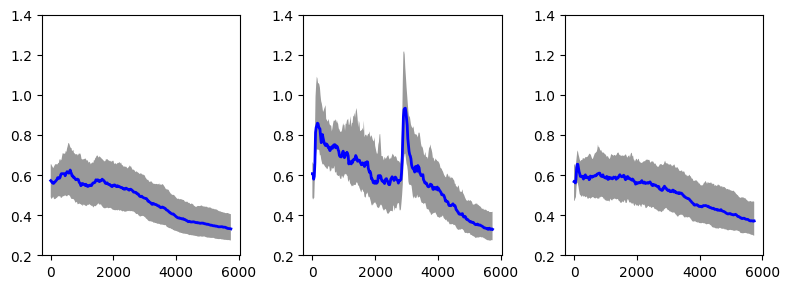

In [80]:
plt.figure(figsize=(8,3))
for g in range(1,4):
    plt.subplot(1,3,g)
    quantiles = np.quantile(x_total[y_total==g].reshape([-1,288]),[0.25,0.5,0.75],axis=0)
    plt.fill(np.concatenate([times,np.flip(times)]),
             np.concatenate([quantiles[0],np.flip(quantiles[2])]),'k',alpha=0.4)
    plt.plot(times,quantiles[1],'b',linewidth=2)
    plt.ylim([0.2,1.4])
plt.tight_layout()

In [81]:
x_train,x_test,y_train,y_test = train_test_split(x_total,y_total,test_size=0.25)
print('x_train,y_train:',x_train.shape,y_train.shape)

x_train,y_train: (6300, 1, 288) (6300,)


In [82]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit(y_train.reshape([-1,1]))
y_train_oh,y_test_oh = one_hot_encoder.transform(y_train.reshape([-1,1])),one_hot_encoder.transform(y_test.reshape([-1,1]))

print('y_train_oh:',y_train_oh.shape)

y_train_oh: (6300, 3)


In [83]:
class ElecDataset(torch.utils.data.Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        return item,label

In [365]:
class Classifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        width = 288
        kernel_width = 10
        n_kernels = 16
        strides = 2
        
        self.conv1 = nn.Conv1d(1, n_kernels, kernel_width, stride=strides)
        new_width = int((width - kernel_width)/2+1)
        self.lin1 = nn.Linear(new_width,new_width)
        self.relu = nn.ReLU()
        
        self.conv2 = nn.Conv1d(n_kernels, n_kernels, kernel_width, stride=strides)
        new_width = int((new_width - kernel_width)/2+1)
        self.lin2 = nn.Linear(new_width,new_width)
        
        self.flat = nn.Flatten()
        self.lin3 = nn.Linear(new_width*n_kernels,256)
        self.lin4 = nn.Linear(256,64)
        self.lin5 = nn.Linear(64,16)
        self.lin6 = nn.Linear(16,3)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.lin1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.lin2(x)
        x = self.relu(x)
        
        x = self.flat(x)
        
        x = self.lin3(x)
        x = self.lin4(x)
        x = self.lin5(x)
        x = self.lin6(x)
        x = self.sigmoid(x)
        return x
    
    def fit(self,x_data,y_data,epochs=1,batch_size=10,validation_split=0.25):
        
        x_train,x_valid,y_train,y_valid = train_test_split(x_data,y_data,test_size=validation_split)
        train_loader = torch.utils.data.DataLoader(ElecDataset(x_train,y_train),batch_size=batch_size,shuffle=False)
        valid_loader = torch.utils.data.DataLoader(ElecDataset(x_valid,y_valid),batch_size=batch_size,shuffle=False)
        self.valid_len = len(y_valid)
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9)
        self.objective_function = nn.CrossEntropyLoss()        
        self = self.float()
        self.train()

        #early stopping:
        trials = 0
        best_acc = 0.0
        #train loop
        self.train_losses = []
        self.valid_losses = []
        self.train_accuracy = []
        self.valid_accuracy = []
        for e in range(epochs):
            train_loss,train_acc = self.trainEpoch(train_loader)
            self.train_losses.append(train_loss)
            self.train_accuracy.append(train_acc)
            self.scheduler.step()
            with torch.no_grad():
                valid_loss,valid_acc = self.trainEpoch(valid_loader,learn=False)
            self.valid_losses.append(valid_loss)
            self.valid_accuracy.append(valid_acc)
            
            #early stopping:
            if valid_acc > best_acc:
                trials = 0
                torch.save(model.state_dict(), 'best.pth')
            else:
                trials += 1
                if trials > patience:
                    break
                    
            clear_output(True)
            self.report()
            
        clear_output(True)
        self.report()
        
    def report(self):
        
        loss_str =  f'train_loss: {self.train_losses[-1]:.5f}, valid_loss: {self.valid_losses[-1]:.5f}'
        acc_str = f'train_accuracy: {self.train_accuracy:.3f}, valid_accuracy: {self.valid_accuracy:.3f}'
        print(f'epoch {e+1:3d}: {loss_str}, {acc_str}')
        self.plotFitting()
        
    def trainEpoch(self,data_loader,learn=True):
        running_loss = 0.0
        running_accuracy = 0.0
        count = 0
        for i,(inp,lab) in enumerate(data_loader):
            count += inp.shape[0]
            if learn:
                self.optimizer.zero_grad()
            preds = self.forward(inp.float())
            
            loss = self.objective_function(preds.double(),lab.double()) 
            if learn:
                loss.backward()
                self.optimizer.step()
            
            running_loss += loss
            running_accuracy += torch.sum(torch.argmax(preds.double(),axis=1) == torch.argmax(lab.double(),axis=1))
        
        train_loss = running_loss/len(data_loader)
        val_acc = running_accuracy/count            
        return train_loss.detach().numpy(),val_acc.detach().numpy()
    
    def plotFitting(self):
        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)
        plt.plot(self.train_losses,label='training')
        plt.plot(self.valid_losses,label='validation')
        plt.ylabel('Loss (Categorial crossentropy)')

        plt.subplot(1,2,2)
        plt.plot(self.train_accuracy,label='training')
        plt.plot(self.valid_accuracy,label='validation')
        plt.ylabel('Accuracy')
        
        plt.tight_layout()
        plt.show()

epoch 100: train_loss: 0.81426, valid_loss: 0.82231, train_accuracy: 0.693, valid_accuracy: 0.687


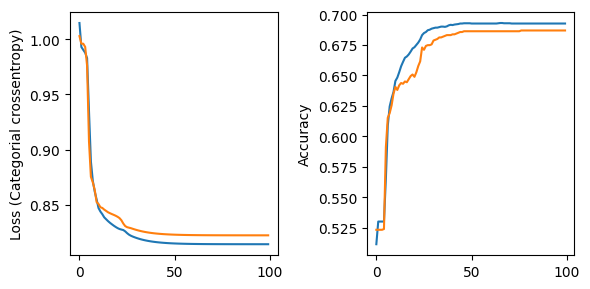

In [362]:
model = Classifier()
model.fit(x_train,y_train_oh,100,batch_size=256)

In [364]:
torch.save(model.state_dict(), 'best.pth')

In [1145]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

def evaluatePerformance(model):
    test_loader = torch.utils.data.DataLoader(ElecDataset(x_test,y_test),batch_size=batch_size,shuffle=False)
    y_test_valid = np.zeros(0)
    for samp,label in test_loader:
        res = model.forward(samp.float())
        y_test_valid = np.concatenate((y_test_valid,np.argmax(res.detach().numpy(),axis=1)+1))
    
    cat_acc = np.mean(y_test_valid == y_test)
    print('correct classified: %.1f %%'%(cat_acc*100))

    conf_mat = confusion_matrix(y_test,y_test_valid)
    conf_mat_disp = ConfusionMatrixDisplay(conf_mat)
    conf_mat_disp.plot()
    print(classification_report(y_test,y_test_valid))

correct classified: 70.5 %
              precision    recall  f1-score   support

         1.0       0.68      0.93      0.79      1150
         2.0       0.85      0.85      0.85       302
         3.0       0.66      0.24      0.35       648

    accuracy                           0.71      2100
   macro avg       0.73      0.67      0.66      2100
weighted avg       0.70      0.71      0.66      2100



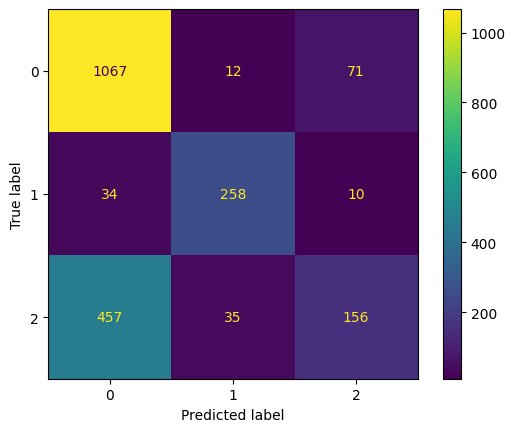

In [1146]:
evaluatePerformance(model)